In [1]:
import typing as tp
import enum as en
import numpy as np
import itertools as it
import more_itertools as mit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy as cp
import dataclasses as dc
import time

In [2]:
from libs.environment.utils import *
from libs.utils.graph import *
from libs.environment.utils import *
from libs.optimizers.algorithms.genetic.operators.mutations import *
from libs.optimizers.algorithms.genetic.operators.crossovers import *
from libs.optimizers.algorithms.genetic.operators.fixers import *
from libs.optimizers.algorithms.genetic.population import Population
from libs.optimizers.algorithms.genetic.population.generators import *
from libs.optimizers.algorithms.genetic.population.parent_selectors import *
from libs.optimizers.algorithms.genetic.population.population_selectors import *
from libs.optimizers.algorithms.genetic.operators.fixers import *

In [3]:
RND_SEED = 0
rng = np.random.default_rng(seed=0)

In [14]:
class CoordsCreation(en.Enum):
    GRID = en.auto()
    RANDOM = en.auto()


def generate_environment(
    grid_size: int,
    speed: float = 2.5,
    max_wind_speed: float = 2,
    transition_prohibition_p: float = 0.05,
    point_distance_std_dev: float = 0.1,
    coords_creation: CoordsCreation = CoordsCreation.GRID,
    max_x: int = 10,
    max_y: int = 10,
    rng: np.random.Generator = rng,
) -> tuple[
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.random.Generator,
]:
    if coords_creation == CoordsCreation.RANDOM:
        coords, rng = coords_random(grid_size, rng, max_x=max_x, max_y=max_y)
    else:
        coords = coords_grid(grid_size)
    distances, rng = point_distances(coords, rng, std_dev=point_distance_std_dev)
    # disable_edges
    permitted_distances, rng = insert_at_random_indices(
        -1, distances, rng, insertion_p=transition_prohibition_p
    )
    wind, rng = wind_random(
        side_size=permitted_distances.shape[0], rng=rng, max_velocity=max_wind_speed
    )
    eff_speed = effective_speed(speed, wind)
    travel_t = travel_times(permitted_distances, eff_speed)
    return coords, distances, permitted_distances, wind, eff_speed, travel_t, rng


def plot_environment_generation_results(
    coords: np.ndarray,
    distances: np.ndarray,
    permitted_distances: np.ndarray,
    wind: np.ndarray,
    eff_speed: np.ndarray,
    travel_t: np.ndarray,
    cmap: str = "hot",
):
    mean_distance = distances.mean()
    coords_df = pd.DataFrame({"x": coords[:, 0], "y": coords[:, 1]})

    fig_spatial, (ax1, ax2, ax3) = plt.subplots(ncols=3)  # type: ignore
    fig_time, (ax4, ax5, ax6) = plt.subplots(ncols=3)  # type: ignore

    sns.scatterplot(x=coords_df.x, y=coords_df.y, ax=ax1)
    ax1.set_title("Random coordinates")
    sns.heatmap(distances, ax=ax2, cmap=cmap)
    ax2.set_title(f"Distance matrix (mean: {mean_distance:.2})")
    sns.heatmap(permitted_distances, ax=ax3, cmap=cmap)
    ax3.set_title("Distance matrix with disabled edges")
    sns.heatmap(wind, ax=ax4, cmap=cmap)
    ax4.set_title("Wind speed matrix")
    sns.heatmap(eff_speed, ax=ax5, cmap=cmap)
    ax5.set_title("Effective speed matrix")
    sns.heatmap(travel_t, ax=ax6, cmap=cmap)
    ax6.set_title("Travel time matrix")

    fig_spatial.show()
    fig_time.show()

    return fig_spatial, fig_time, (ax1, ax2, ax3), (ax4, ax5, ax6)

In [15]:
(
    coords,
    distances,
    permitted_distances,
    wind,
    eff_speed,
    travel_t,
    rng,
) = generate_environment(
    grid_size=10,
    speed=2.5,
    max_wind_speed=2,
    transition_prohibition_p=0.05,
    point_distance_std_dev=0.1,
    coords_creation=CoordsCreation.GRID,
    max_x=10,
    max_y=10,
    rng=rng,
)

C:\Users\obszansk\AppData\Local\Temp/ipykernel_10944/165037873.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_spatial.show()
C:\Users\obszansk\AppData\Local\Temp/ipykernel_10944/165037873.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_time.show()


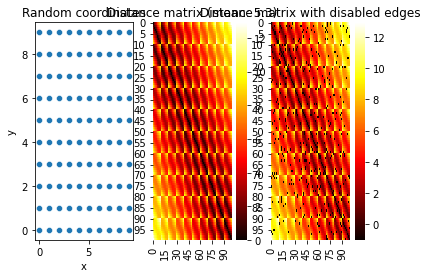

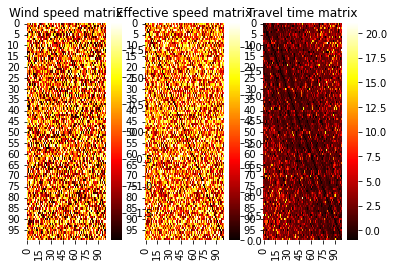

In [16]:
fig1, fig2, ax1, axs2 = plot_environment_generation_results(
    coords,
    distances,
    permitted_distances,
    wind,
    eff_speed,
    travel_t,
    cmap = "hot",
)

In [10]:
environment = EnvironmentTSPSimple(travel_t)

In [11]:
solution_creator = SolutionCreatorTSPSimpleHeuristicNN()
greedy_solution = solution_creator.create(environment, initial_vx=0)
greedy_solution

SolutionRepresentationTSP(representation=[0, 8, 11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3])

In [12]:
vxs = list(range(coords.shape[0]))
print(
    f"{len(greedy_solution.representation) = }, success: {set(greedy_solution.representation) == set(vxs)}"
)

len(greedy_solution.representation) = 20, success: True


In [13]:
cost_calculator = TSPCostCalculatorSimple()
total_cost, step_cost = cost_calculator.calculate_total(greedy_solution, environment)
total_cost, step_cost

(14.704770576550509,
 deque([0.5678337143867346,
        0.6573866652242365,
        0.6163839210623999,
        0.29500500914178013,
        0.8402380034334131,
        0.18782646059885555,
        0.5747184564105766,
        1.4840688164694997,
        0.4548711209153218,
        0.6717449750888875,
        1.2141009222073795,
        0.08876899078840716,
        1.4814778379302609,
        1.5087020287501967,
        1.1819800001360146,
        2.586630968849158,
        0.17184279148858422,
        0.03535656043810125,
        0.08583333323069842]))

In [14]:
for i, cost in enumerate(cost_calculator.stepper(greedy_solution, environment)):
    print(f"{i = }, {cost = }")

i = 0, cost = 0.5678337143867346
i = 1, cost = 0.6573866652242365
i = 2, cost = 0.6163839210623999
i = 3, cost = 0.29500500914178013
i = 4, cost = 0.8402380034334131
i = 5, cost = 0.18782646059885555
i = 6, cost = 0.5747184564105766
i = 7, cost = 1.4840688164694997
i = 8, cost = 0.4548711209153218
i = 9, cost = 0.6717449750888875
i = 10, cost = 1.2141009222073795
i = 11, cost = 0.08876899078840716
i = 12, cost = 1.4814778379302609
i = 13, cost = 1.5087020287501967
i = 14, cost = 1.1819800001360146
i = 15, cost = 2.586630968849158
i = 16, cost = 0.17184279148858422
i = 17, cost = 0.03535656043810125
i = 18, cost = 0.08583333323069842


In [15]:
rnd_sol_creator = SolutionCreatorTSPSimpleRandom()
rnd_sol = rnd_sol_creator.create(environment, initial_vx=0)
print(
    f"{len(rnd_sol.representation) = }, success: {set(rnd_sol.representation) == set(vxs)}"
)

len(rnd_sol.representation) = 20, success: True


## Poisson distribution

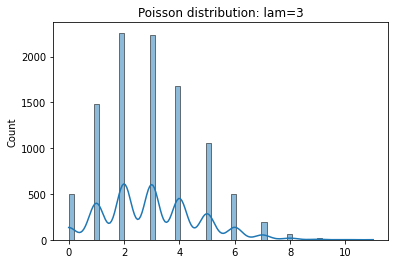

In [16]:
lam = 3
poisson_points = np.random.poisson(lam=lam, size=10000)
ax = sns.histplot(data=poisson_points, kde=True)
_ = ax.set_title(f"Poisson distribution: lam={lam}")

In [17]:
mutator_swap = MutatorHomogenousVectorSwap(probability=1, lam=1)
mutator_shuffle = MutatorHomogenousVectorShuffle(probability=1, lam=1)
chromosome = ChromosomeHomogenousVector(greedy_solution.representation)

In [18]:
mutated, _ = mutator_swap.mutate(chromosome)
print(f"{chromosome.sequence = }\n{mutated.sequence    = }")

chromosome.sequence = [0, 8, 11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3]
mutated.sequence    = [0, 8, 3, 4, 13, 12, 7, 14, 10, 5, 9, 17, 15, 1, 16, 6, 2, 18, 19, 11]


In [19]:
mutated, _ = mutator_shuffle.mutate(chromosome)
print(f"{chromosome.sequence = }\n{mutated.sequence    = }")

chromosome.sequence = [0, 8, 11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3]
mutated.sequence    = [11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3, 0, 8]


In [20]:
for i in range(10):
    if i > 10:
        break
else:
    print("makapaka")

makapaka


In [21]:
print(f"success: {set(chromosome.sequence) == set(mutated.sequence)}")

success: True


In [22]:
crossover_normal = CrossoverHomogenousVector()
crossover_kpoint = CrossoverHomogenousVectorKPoint()
crossover_kpoint_random = CrossoverHomogenousVectorKPointPoisson(lam=0.5)

In [23]:
chromosome1 = ChromosomeHomogenousVector(greedy_solution.representation)
chromosome2 = ChromosomeHomogenousVector(rnd_sol.representation)

In [24]:
new_generation_normal = crossover_normal.execute(chromosome1, chromosome2)
new_generation_kpoint = crossover_kpoint.execute(chromosome1, chromosome2, k=3)
new_generation_kpoint_random = crossover_kpoint_random.execute(chromosome1, chromosome2)

In [25]:
print(
    f"parents:\n\t{chromosome1.sequence} (len: {len(chromosome1.sequence)})\n\t{chromosome2.sequence} (len: {len(chromosome2.sequence)})"
)
print(
    f"normal:\n\t{new_generation_normal[0].sequence} (len: {len(new_generation_normal[0].sequence)})\n\t{new_generation_normal[1].sequence} (len: {len(new_generation_normal[1].sequence)})"
)
print(
    f"k-point:\n\t{new_generation_kpoint[0].sequence} (len: {len(new_generation_kpoint[0].sequence)})\n\t{new_generation_kpoint[1].sequence} (len: {len(new_generation_kpoint[1].sequence)})"
)

parents:
	[0, 8, 11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3] (len: 20)
	[0, 12, 7, 9, 5, 13, 2, 1, 6, 14, 15, 17, 4, 16, 11, 3, 8, 18, 10, 19] (len: 20)
normal:
	[18, 19, 3, 0, 12, 7, 9, 5, 13, 2, 1, 6, 14, 15, 17, 4, 16, 11, 3, 8] (len: 20)
	[18, 10, 19, 0, 8, 11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6] (len: 20)
k-point:
	[0, 8, 11, 4, 13, 13, 2, 16, 10, 5, 15, 17, 4, 16, 11, 3, 8, 18, 10, 19] (len: 20)
	[0, 12, 7, 9, 5, 12, 7, 1, 6, 14, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3] (len: 20)


Note - Crossover is useless for TSP and other problems, where values can not repeat themselves.

In [26]:
bad_chromosome = cp.deepcopy(chromosome1)
bad_chromosome.sequence[2:6] = bad_chromosome.sequence[7:11]

In [27]:
fixer = ChromosomeFixerTSPSimple()

In [28]:
fixed_chromosome, should_die = fixer.fix(bad_chromosome, environment)
should_die, fixed_chromosome

(FixResult(fix_status=<FixStatus.SUCCESS: 1>, no_of_errors=0),
 ChromosomeHomogenousVector(sequence=[0, 8, 16, 10, 5, 15, 7, 12, 11, 4, 13, 17, 2, 1, 14, 9, 6, 18, 19, 3]))

In [29]:
print(f"success: {set(fixed_chromosome.sequence) == set(vxs)}")

success: True


## New population generation

In [30]:
POPULATION_SIZE = 10
solution_creator_heuristic = SolutionCreatorTSPSimpleHeuristicNN()
solution_creator_random = SolutionCreatorTSPSimpleRandom()
heuristic_solution = solution_creator.create(environment, initial_vx=0)
random_solutions = [
    solution_creator_random.create(environment, initial_vx=0)
    for _ in range(POPULATION_SIZE - 1)
]

In [31]:
population: Population = [
    ChromosomeHomogenousVector(sol.representation)
    for sol in mit.value_chain(heuristic_solution, random_solutions)
]
population

[ChromosomeHomogenousVector(sequence=[0, 8, 11, 4, 13, 12, 7, 16, 10, 5, 15, 17, 2, 1, 14, 9, 6, 18, 19, 3]),
 ChromosomeHomogenousVector(sequence=[0, 10, 4, 14, 9, 16, 1, 13, 8, 5, 19, 15, 12, 11, 17, 18, 2, 7, 6, 3]),
 ChromosomeHomogenousVector(sequence=[0, 6, 14, 18, 16, 8, 17, 19, 15, 12, 4, 11, 10, 9, 1, 5, 3, 7, 2, 13]),
 ChromosomeHomogenousVector(sequence=[0, 17, 1, 14, 15, 2, 4, 6, 16, 13, 19, 9, 3, 7, 5, 8, 10, 18, 11, 12]),
 ChromosomeHomogenousVector(sequence=[0, 6, 13, 10, 1, 17, 4, 3, 7, 16, 2, 12, 14, 11, 19, 9, 15, 18, 5, 8]),
 ChromosomeHomogenousVector(sequence=[0, 3, 15, 14, 6, 1, 5, 11, 16, 18, 17, 19, 9, 10, 4, 13, 12, 2, 7, 8]),
 ChromosomeHomogenousVector(sequence=[0, 15, 12, 8, 4, 14, 7, 3, 9, 1, 13, 19, 6, 10, 11, 2, 16, 5, 17, 18]),
 ChromosomeHomogenousVector(sequence=[0, 8, 2, 17, 16, 3, 9, 7, 18, 12, 4, 1, 13, 11, 15, 14, 10, 19, 6, 5]),
 ChromosomeHomogenousVector(sequence=[0, 15, 6, 9, 19, 2, 7, 5, 17, 18, 12, 13, 3, 10, 14, 16, 4, 11, 1, 8]),
 Chromosom

In [32]:
cost_calculator = TSPCostCalculatorSimple()
parent_selector = ParentSelectorElitistRandomized()
population_selector = PopulationSelectorProbabilistic()
mutators = [
    MutatorHomogenousVectorSwap(probability=0.1, lam=0.5),
    MutatorHomogenousVectorShuffle(probability=0.1, lam=0.5),
]
crossover = CrossoverHomogenousVectorKPointPoisson(lam=0.5)
fixer = ChromosomeFixerTSPSimple()
generation_generator = PopulationGenerator()

max_cost = max(filter(lambda x: x > 0 and math.isfinite(x), np.nditer(environment.cost)))  # type: ignore
mean_cost = np.mean(
    [x for x in np.nditer(environment.cost) if x > 0 and math.isfinite(x)]
)

invalidity_weight = 0.2 * mean_cost
error_weight = 0.05 * mean_cost
cost_weight = 1

In [33]:
next_generation, population_generation_data = generation_generator.generate(
    population,
    environment,
    cost_calculator,
    parent_selector,
    mutators,
    crossover,
    fixer,
    population_selector,
    invalidity_weight,
    error_weight,
    cost_weight,
)
next_generation

[ChromosomeHomogenousVector(sequence=[0, 6, 14, 18, 16, 8, 17, 19, 15, 12, 4, 11, 10, 9, 1, 5, 2, 3, 7, 13]),
 ChromosomeHomogenousVector(sequence=[0, 17, 1, 14, 15, 2, 4, 6, 16, 13, 19, 9, 3, 7, 5, 8, 10, 18, 11, 12]),
 ChromosomeHomogenousVector(sequence=[0, 15, 12, 8, 4, 14, 7, 3, 9, 1, 13, 19, 6, 10, 11, 2, 16, 5, 17, 18]),
 ChromosomeHomogenousVector(sequence=[0, 6, 14, 18, 16, 8, 17, 19, 15, 12, 4, 11, 10, 9, 1, 5, 3, 7, 2, 13]),
 ChromosomeHomogenousVector(sequence=[0, 6, 13, 10, 1, 17, 4, 3, 7, 16, 2, 12, 14, 11, 19, 18, 15, 8, 5, 9]),
 ChromosomeHomogenousVector(sequence=[0, 15, 6, 9, 19, 2, 7, 5, 17, 18, 12, 13, 3, 10, 14, 16, 4, 11, 1, 8]),
 ChromosomeHomogenousVector(sequence=[0, 15, 6, 9, 19, 2, 7, 5, 17, 18, 12, 13, 3, 10, 14, 16, 8, 11, 4, 1]),
 ChromosomeHomogenousVector(sequence=[0, 10, 4, 14, 9, 16, 1, 13, 8, 5, 19, 15, 12, 11, 17, 18, 2, 7, 6, 3]),
 ChromosomeHomogenousVector(sequence=[0, 6, 13, 10, 1, 17, 4, 3, 7, 16, 2, 12, 14, 11, 19, 9, 15, 18, 5, 8]),
 Chromosom

## Genetic algorithm

In [34]:
class GeneticAlgorithmFinishReason(en.Enum):
    MAX_ITERATIONS = en.auto()
    MAX_ITERATIONS_NO_UPDATE = en.auto()
    TIMEOUT = en.auto()


@dc.dataclass
class GeneticAlgorithmExecutionData:
    best_chromosome: Chromosome
    best_cost: CostT
    initial_population: Population
    initial_best_cost: CostT
    end_population: Population
    iteration_best_costs: list[CostT]
    execution_time: float
    finish_reason: GeneticAlgorithmFinishReason
    last_iteration_n: int


def genetic_algorithm_tsp_simple_test(
    max_iterations: int,
    max_iterations_no_update: int,
    timeout: float,
    swap_p: float,
    swap_lam: float,
    shuffle_p: float,
    shuffle_lam: float,
    crossover_lam: float,
    invalidity_weight: float,
    error_weight: float,
    cost_weight: float,
) -> GeneticAlgorithmExecutionData:
    t0 = time.time()

    POPULATION_SIZE = 10
    solution_creator_heuristic = SolutionCreatorTSPSimpleHeuristicNN()
    solution_creator_random = SolutionCreatorTSPSimpleRandom()
    heuristic_solution = solution_creator_heuristic.create(environment, initial_vx=0)
    random_solutions = [
        solution_creator_random.create(environment, initial_vx=0)
        for _ in range(POPULATION_SIZE - 1)
    ]

    initial_population: Population = [
        ChromosomeHomogenousVector(sol.representation)
        for sol in mit.value_chain(heuristic_solution, random_solutions)
    ]

    cost_calculator = TSPCostCalculatorSimple()
    parent_selector = ParentSelectorElitistRandomized()
    population_selector = PopulationSelectorProbabilistic()
    mutators = [
        MutatorHomogenousVectorSwap(probability=swap_p, lam=swap_lam),
        MutatorHomogenousVectorShuffle(probability=shuffle_p, lam=shuffle_lam),
    ]
    crossover = CrossoverHomogenousVectorKPointPoisson(lam=crossover_lam)
    fixer = ChromosomeFixerTSPSimple()
    generation_generator = PopulationGenerator()

    current_population = cp.copy(initial_population)

    initial_best_chromosome = initial_population[0]

    initial_best_cost, _ = cost_calculator.calculate_total(
        SolutionRepresentationTSP(initial_best_chromosome.sequence), environment
    )

    for chromosome in initial_population[1:]:
        current_cost, _ = cost_calculator.calculate_total(
            SolutionRepresentationTSP(chromosome.sequence), environment
        )

        if current_cost < initial_best_cost:
            initial_best_chromosome = chromosome
            initial_best_cost = current_cost

    iteration_since_last_update = 0
    NaN = float("NaN")
    iteration_best_costs: list[CostT] = [NaN for _ in range(max_iterations)]
    best_chromosome = cp.deepcopy(initial_best_chromosome)
    best_cost = initial_best_cost

    for i in range(max_iterations):
        delta_t = time.time() - t0

        if (reason_timeout := (delta_t > timeout)) or (
            reason_iterations := (
                iteration_since_last_update > max_iterations_no_update
            )
        ):
            reason = (
                GeneticAlgorithmFinishReason.TIMEOUT
                if reason_timeout
                else GeneticAlgorithmFinishReason.MAX_ITERATIONS_NO_UPDATE
            )

            return GeneticAlgorithmExecutionData(
                best_chromosome,
                best_cost,
                initial_population,
                initial_best_cost,
                end_population=current_population,
                iteration_best_costs=iteration_best_costs,
                execution_time=delta_t,
                finish_reason=reason,
                last_iteration_n=i,
            )

        current_population, population_generation_data = generation_generator.generate(
            current_population,
            environment,
            cost_calculator,
            parent_selector,
            mutators,
            crossover,
            fixer,
            population_selector,
            invalidity_weight,
            error_weight,
            cost_weight,
        )

        costs = population_generation_data["new_costs"]

        current_best_chromosome = next_generation[0]
        current_best_cost = costs[0]

        for chromosome, cost in zip(next_generation[1:], costs[1:]):
            if cost < current_best_cost:
                current_best_chromosome = chromosome
                current_best_cost = cost

        iteration_best_costs[i] = current_best_cost

        if current_best_cost < best_cost:
            best_chromosome = current_best_chromosome
            best_cost = current_best_cost
            iteration_since_last_update = 0
        else:
            iteration_since_last_update += 1

    return GeneticAlgorithmExecutionData(
        best_chromosome,
        best_cost,
        initial_population,
        initial_best_cost,
        end_population=current_population,
        iteration_best_costs=iteration_best_costs,
        execution_time=time.time() - t0,
        finish_reason=GeneticAlgorithmFinishReason.MAX_ITERATIONS,
        last_iteration_n=max_iterations - 1,
    )

In [35]:
max_cost = max(filter(lambda x: x > 0 and math.isfinite(x), np.nditer(environment.cost)))  # type: ignore
mean_cost = np.mean(
    [x for x in np.nditer(environment.cost) if x > 0 and math.isfinite(x)]
)

invalidity_weight = 0.2 * mean_cost
error_weight = 0.05 * mean_cost
cost_weight = 1

result = genetic_algorithm_tsp_simple_test(
    max_iterations=1000,
    max_iterations_no_update=100,
    timeout=60,
    swap_p=0.05,
    swap_lam=1,
    shuffle_p=0.05,
    shuffle_lam=1,
    crossover_lam=1,
    invalidity_weight=invalidity_weight,
    error_weight=error_weight,
    cost_weight=cost_weight,
)

print(
    (
        f"{result.finish_reason     = }\n"
        f"{result.execution_time    = }\n"
        f"{result.last_iteration_n  = }\n"
        f"{result.initial_best_cost = }\n"
        f"{result.best_cost         = }"
    )
)

result.finish_reason     = <GeneticAlgorithmFinishReason.TIMEOUT: 3>
result.execution_time    = 68.1552734375
result.last_iteration_n  = 15
result.initial_best_cost = 14.704770576550509
result.best_cost         = 14.704770576550509


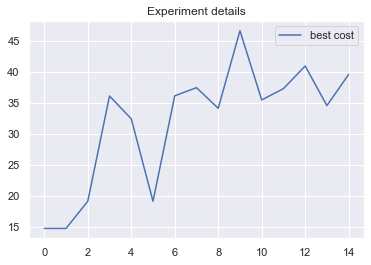

In [36]:
data = pd.DataFrame(
    data=result.iteration_best_costs,
    columns=["best cost"],
    # index=[("iteration", i) for i in range(len(result.iteration_best_costs))]
)
sns.set_theme()
ax = sns.lineplot(data=data)
_ = ax.set_title("Experiment details")

## experiment0

In [37]:
print("initializing environment")

coords = coords_random(5, max_x=10, max_y=10)
distances = coords_distances(coords, std_dev=0.1)
permitted_distances = disable_edges(distances, prohibition_p=0.1)
wind = wind_random(permitted_distances, max_velocity=1)
speed = 2.5
eff_speed = effective_speed(speed, wind)
travel_t = travel_times(distances, eff_speed)
environment = EnvironmentTSPSimple(travel_t)

solution_creator_heuristic = SolutionCreatorTSPSimpleHeuristicNN()
heuristic_solution = solution_creator_heuristic.create(environment, initial_vx=0)
cost_calculator = TSPCostCalculatorSimple()
heuristic_cost = cost_calculator.calculate_total(heuristic_solution, environment)

max_cost = max(filter(lambda x: x > 0 and math.isfinite(x), np.nditer(environment.cost)))  # type: ignore
mean_cost = np.mean(
    [x for x in np.nditer(environment.cost) if x > 0 and math.isfinite(x)]
)

invalidity_weight = 0.2 * mean_cost
error_weight = 0.05 * mean_cost
cost_weight = 1

print("calling the algorithm")

initializing environment
calling the algorithm


In [38]:
?plt.savefig

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, dpi=None, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=None, metadata=None)

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or binary file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there is one.  If *format* is not
    set and *fname* has n

## MTSP development - matrix

In [12]:
SALESMAN_N = 4
VERTICES_N = 8
MAX_CHROMOSOME_LEN = VERTICES_N

vertices = list(range(VERTICES_N))
mx_height, mx_width = SALESMAN_N, MAX_CHROMOSOME_LEN

all_ixs = list(it.product(range(SALESMAN_N), range(MAX_CHROMOSOME_LEN)))
coord_ixs = np.random.choice(len(all_ixs), size=len(vertices), replace=False)
vertex_ixs = tuple(np.array(list(all_ixs[i] for i in coord_ixs)).T.tolist())
dbg_xys = [(x, y) for x, y in zip(vertex_ixs[0], vertex_ixs[1])]
print(f"xys: {dbg_xys}({len(dbg_xys)})")

mx = -np.ones(shape=(mx_height, mx_width), dtype=np.float64)
mx[vertex_ixs] = vertices
sum(1 for x in np.nditer(mx) if x != -1) == VERTICES_N

xys: [(1, 4), (2, 4), (3, 7), (0, 6), (2, 6), (2, 5), (0, 3), (2, 0)](8)


True

In [13]:
mx, set(vertices) - set(float(x) for x in np.nditer(mx))

(array([[-1., -1., -1.,  6., -1., -1.,  3., -1.],
        [-1., -1., -1., -1.,  0., -1., -1., -1.],
        [ 7., -1., -1., -1.,  1.,  5.,  4., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  2.]]),
 set())

In [14]:
def swap_random_matrix_vxs
# TODO maybe two functions - to draw indices of vertices to swap and to actually swap

SyntaxError: invalid syntax (Temp/ipykernel_20960/1887764639.py, line 1)

In [15]:
T1 = tp.TypeVar("T1")
T2 = tp.TypeVar("T2")
T3 = tp.TypeVar("T3")


def rand_fill_to_n(
    seq: tp.Sequence[T1],
    fill_val: T2,
    n: int,
) -> list[Union[T1, T2]]:
    """
    Assumes that `n >= len(c1)`
    """

    seq_len = len(seq)
    diff = n - seq_len

    if diff < 0:
        raise ValueError(
            "`n` has to be greater than `len(seq)`", {"n": n, "seq_len": seq_len}
        )

    if diff == 0:
        return list(seq)

    filler_ixs = sorted(np.random.choice(seq_len, size=diff))
    shorter_chunk_ixs = mit.windowed(mit.value_chain(0, filler_ixs, n), n=2)

    return list(
        it.chain.from_iterable(
            mit.intersperse(  # type: ignore
                [fill_val], (seq[i:j] for i, j in shorter_chunk_ixs)
            )
        )
    )


def rand_fill_shorter(
    c1: tp.Sequence[T1], c2: tp.Sequence[T2], fill_val: T3
) -> tuple[tp.Sequence[Union[T1, T2, T3]], tp.Sequence[Union[T1, T2, T3]]]:
    c1_len = len(c1)
    c2_len = len(c2)
    shorter, longer, shorter_len, longer_len = (
        (c1, c2, c1_len, c2_len) if c1_len < c2_len else (c2, c1, c2_len, c1_len)
    )

    filled_shorter = rand_fill_to_n(shorter, fill_val, n=longer_len)  # type: ignore

    return filled_shorter, longer  # type: ignore

In [16]:
c1, c2 = rand_fill_shorter(list(range(10)), list(range(6)), -1)
len(c1) == len(c2)

True

In [17]:
foo = np.arange(12).reshape((2, 6))
for row in foo:
    print(row[row % 2 == 0])

[0 2 4]
[ 6  8 10]


In [18]:
def shorten_filled(mx: np.ndarray, fill_val) -> np.ndarray:
    """
    Reduces max row size to size of a row with the greatest number
    of non-`fill_val` values.
    """

    not_fill_vals = mx != fill_val
    print(f"{not_fill_vals = }")
    reduced_row_len = max(len(row[row == True]) for row in not_fill_vals)
    print(f"{reduced_row_len = }")

    return np.array(
        [rand_fill_to_n(row[row != fill_val], fill_val, reduced_row_len) for row in mx]
    )


shorten_filled(mx, fill_val=(-1))

not_fill_vals = array([[False, False, False,  True, False, False,  True, False],
       [False, False, False, False,  True, False, False, False],
       [ True, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False, False, False,  True]])
reduced_row_len = 4


array([[-1.,  6., -1.,  3.],
       [-1., -1., -1.,  0.],
       [ 7.,  1.,  5.,  4.],
       [-1., -1., -1.,  2.]])

In [19]:
def spy_iter(coll):
    for i, elem in enumerate(coll):
        print(f"coll[{i}] = {elem}")
    return coll

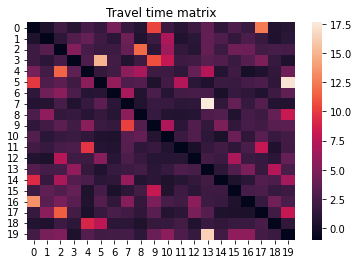

In [20]:
ax = sns.heatmap(travel_t)
_ = ax.set_title("Travel time matrix")

In [50]:
def extend_cost_mx(mx: np.ndarray, copy_n: int, to_copy_ix: int) -> np.ndarray:
    """
    Extends `mx` by copying `to_copy_ix`'th row and column `copy_n` times.
    """

    n_columns = np.repeat(np.array([mx[:, to_copy_ix]]).T, copy_n, axis=1)
    n_rows = np.repeat(np.array([mx[to_copy_ix, :]]).T, copy_n, axis=1).T
    copy_to_copy_costs = np.full(shape=(copy_n, copy_n), fill_value=mx[0, 0])

    # fmt: off
    return np.block([
        [copy_to_copy_costs, n_rows],
        [n_columns,          mx    ]
    ])
    # fmt: on

In [51]:
np.repeat(np.array([[1, 2, 3]]).T, 2, axis=1).T

array([[1, 2, 3],
       [1, 2, 3]])

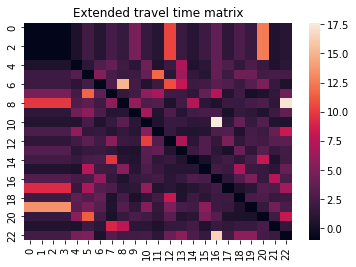

In [52]:
extended_travel_t = extend_cost_mx(travel_t, copy_n=3, to_copy_ix=0)
ax = sns.heatmap(extended_travel_t)
_ = ax.set_title("Extended travel time matrix")

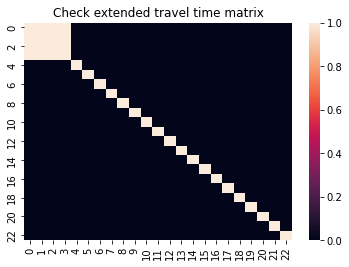

In [53]:
check_extended_travel_t = extended_travel_t == -1
ax = sns.heatmap(check_extended_travel_t)
_ = ax.set_title("Check extended travel time matrix")

In [58]:
initial_sol = [0] + [
    list(range(1, 10))[i] for i in np.random.choice(9, size=9, replace=False)
]
initial_sol

[0, 3, 7, 2, 5, 6, 8, 9, 1, 4]

In [ ]:
def list_from_seed_list(seed: list[int]) -> list[int]:
    """
    Swaps
    """

In [70]:
rng1 = np.random.default_rng()
print(rng1.integers(10))
rng2 = np.random.default_rng()
print(rng2.integers(10))

0
2


In [81]:
def create_tsp_solution_random(
    cost_mx: np.ndarray, initial_vx: int, rng: np.random.Generator
):
    vx_n = cost_mx.shape[0]
    solution_tail = list(set(range(vx_n)) - {initial_vx})
    rng.shuffle(solution_tail)
    return [initial_vx] + solution_tail


create_tsp_solution_random(np.arange(9).reshape((3, 3)), 0, rng1)

[0, 1, 2]

In [1]:
from libs.schemas import ExperimentTSPSchema

In [2]:
schema = ExperimentTSPSchema()
config = {"maka_from_path": "data/dummy_data.yaml", "dummy_enum": "A"}
schema.load(config).maka_from_path

in pre load: data = {'maka_from_path': 'data/dummy_data.yaml', 'dummy_enum': 'A'}
checked numeric
checked enums
loaded paths
loaded registers
parsing paths
converting or not: field.name = 'maka_from_path', field.type = <class 'str'>, {'is_path': True}
converting or not: field.name = 'dummy_enum', field.type = <enum 'DummyEnum'>, {}


WindowsPath('data/dummy_data.yaml')